In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from itertools import product

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [4]:
shop = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
item = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
sales_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')

## 学習データ作成

In [5]:
#店舗の重複を除外
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

sales_train.loc[sales_train['shop_id'] == 11, 'shop_id'] = 10
test.loc[test['shop_id'] == 11, 'shop_id'] = 10


In [6]:
#外れ値を除外
sales_train = sales_train[sales_train['item_price'] <= 50000 ]
sales_train = sales_train[sales_train['item_cnt_day'] <= 1000 ]

In [7]:
# 月単位に集約する
df = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train['date_block_num'] == i]
    df.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
# 負例
#    df.append(np.array(list(product([i], shop['shop_id'].unique(), item['item_id'].unique())), dtype='int16'))
    
df = pd.DataFrame(np.vstack(df), columns=cols)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df.sort_values(cols,inplace=True)

In [8]:
# 学習データとテストデータを結合する
test_tmp = test
test_tmp.insert(0, 'date_block_num', 34)

test_tmp['date_block_num'] = test_tmp['date_block_num'].astype(np.int8)
test_tmp['shop_id'] = test_tmp['shop_id'].astype(np.int8)
test_tmp['item_id'] = test_tmp['item_id'].astype(np.int16)

df = pd.concat([df, test_tmp])
df['ID'] = df['ID'].fillna(0).astype(np.int32)


In [9]:
print(df)

        date_block_num  shop_id  item_id      ID
114910               0        2       19       0
117150               0        2       27       0
120623               0        2       28       0
118316               0        2       29       0
114602               0        2       32       0
...                ...      ...      ...     ...
214195              34       45    18454  214195
214196              34       45    16188  214196
214197              34       45    15757  214197
214198              34       45    19648  214198
214199              34       45      969  214199

[11127956 rows x 4 columns]


In [10]:
# 予測対象となるitem_cnt_monthを生成する
## date_block_num単位に集計、item_cnt_monthをClipする
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','shop_id','item_id'], how='left')
df['item_cnt_month'] = (df['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

In [11]:
# month を切り出す
month = sales_train.loc[:,['date_block_num','date']]
month['month'] = month['date'].str.split('.').map(lambda x: x[1]).astype(np.int8)

month = month.loc[:,['date_block_num','month']].drop_duplicates()
print(month)

         date_block_num  month
0                     0      1
115690                1      2
224303                2      3
345650                3      4
439759                4      5
531518                5      6
631921                6      7
732469                7      8
837241                8      9
933378                9     10
1027580              10     11
1124316              11     12
1267562              12      1
1366911              13      2
1456741              14      3
1549474              15      4
1627380              16      5
1705909              17      6
1788317              18      7
1867077              19      8
1953691              20      9
2026848              21     10
2106209              22     11
2192637              23     12
2323423              24      1
2411945              25      2
2483753              26      3
2553730              27      4
2610004              28      5
2664552              29      6
2719169              30      7
2774718 

In [12]:
#アイテムごとにitem_cnt_monthの平均値作成
item_cnt_month_avg = df.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
item_cnt_month_avg.columns = ['item_cnt_month_avg']
item_cnt_month_avg.reset_index(inplace=True)

item_cnt_month_avg['item_cnt_month_avg'] = (item_cnt_month_avg['item_cnt_month_avg'].fillna(0).astype(np.float16))

print(item_cnt_month_avg)

        date_block_num  item_id  item_cnt_month_avg
0                    0       19            0.022217
1                    0       27            0.155518
2                    0       28            0.177734
3                    0       29            0.088867
4                    0       32            5.378906
...                ...      ...                 ...
239005              34    22162            0.000000
239006              34    22163            0.000000
239007              34    22164            0.000000
239008              34    22166            0.000000
239009              34    22167            0.000000

[239010 rows x 3 columns]


In [13]:
#前月の平均価格を生成
price_mean = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
price_mean.columns = ['price_mean']
price_mean.reset_index(inplace=True)

print(price_mean)

         date_block_num  shop_id  item_id  price_mean
0                     0        2       27      2499.0
1                     0        2       33       499.0
2                     0        2      317       299.0
3                     0        2      438       299.0
4                     0        2      471       399.0
...                 ...      ...      ...         ...
1609117              33       59    22087       119.0
1609118              33       59    22088       119.0
1609119              33       59    22091       179.0
1609120              33       59    22100       629.0
1609121              33       59    22102      1250.0

[1609122 rows x 4 columns]


In [14]:
# アイテムのカテゴリの細分化
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['first'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['item_type'] = LabelEncoder().fit_transform(item_categories['first']).astype(np.int8)

item_categories['other'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['item_subtype'] = LabelEncoder().fit_transform(item_categories['other']).astype(np.int8)
item_categories = item_categories[['item_category_id','item_type', 'item_subtype']]

item = pd.merge(item.drop('item_name', axis=1), item_categories, on=['item_category_id'], how='left')
print(item)

       item_id  item_category_id  item_type  item_subtype
0            0                40         11             4
1            1                76         15            31
2            2                40         11             4
3            3                40         11             4
4            4                40         11             4
...        ...               ...        ...           ...
22165    22165                31          8            61
22166    22166                54         12            61
22167    22167                49         12            39
22168    22168                62         14            28
22169    22169                69         14            56

[22170 rows x 4 columns]


In [15]:
#アイテムカテゴリ事の平均売上
item_cnt_month_category_avg = pd.merge(df, item, on=['item_id'], how='left').drop(columns=['item_id','item_type','item_subtype'])
item_cnt_month_category_avg['item_category_id'] = item_cnt_month_category_avg['item_category_id'].astype(np.int8)

item_cnt_month_category_avg = item_cnt_month_category_avg.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': ['mean']})
item_cnt_month_category_avg.columns = ['item_cnt_month_category_avg']
item_cnt_month_category_avg.reset_index(inplace=True)

item_cnt_month_category_avg['item_cnt_month_category_avg'] = (item_cnt_month_category_avg['item_cnt_month_category_avg'].fillna(0).astype(np.float16))

print(item_cnt_month_category_avg)


      date_block_num  item_category_id  item_cnt_month_category_avg
0                  0                 0                     0.022217
1                  0                 1                     0.022217
2                  0                 2                     0.835449
3                  0                 3                     4.421875
4                  0                 4                     0.513184
...              ...               ...                          ...
2134              34                76                     0.000000
2135              34                77                     0.000000
2136              34                78                     0.000000
2137              34                79                     0.000000
2138              34                83                     0.000000

[2139 rows x 3 columns]


In [16]:
# 店舗のカテゴリ化
shop['city'] = shop['shop_name'].str.split(' ').map(lambda x: x[0])
shop.loc[shop['city'] == '!Якутск', 'city'] = 'Якутск' # 変な重複の除外
shop['city_id'] = LabelEncoder().fit_transform(shop['city']).astype(np.int8)
shop = shop[['shop_id','city_id']]

In [17]:
print(df)

          date_block_num  shop_id  item_id      ID  item_cnt_month
0                      0        2       19       0             0.0
1                      0        2       27       0             1.0
2                      0        2       28       0             0.0
3                      0        2       29       0             0.0
4                      0        2       32       0             0.0
...                  ...      ...      ...     ...             ...
11127951              34       45    18454  214195             0.0
11127952              34       45    16188  214196             0.0
11127953              34       45    15757  214197             0.0
11127954              34       45    19648  214198             0.0
11127955              34       45      969  214199             0.0

[11127956 rows x 5 columns]


In [18]:
# 特徴量を追加
#month
df = pd.merge(df, month, on=['date_block_num'], how='left')

#平均売上個数
df = pd.merge(df, item_cnt_month_avg, on=['date_block_num','item_id'], how='left')

#平均価格
df = pd.merge(df, price_mean, on=['date_block_num','shop_id','item_id'], how='left')

#アイテムカテゴリ
df = pd.merge(df, item, on=['item_id'], how='left')
df['item_category_id'] = df['item_category_id'].astype(np.int8)

#アイテムカテゴリごとの売り上げ平均
df = pd.merge(df, item_cnt_month_category_avg, on=['date_block_num','item_category_id'], how='left')

#city_id
df = pd.merge(df, shop, on=['shop_id'], how='left')


In [19]:
print(df)

          date_block_num  shop_id  item_id      ID  item_cnt_month  month  \
0                      0        2       19       0             0.0    1.0   
1                      0        2       27       0             1.0    1.0   
2                      0        2       28       0             0.0    1.0   
3                      0        2       29       0             0.0    1.0   
4                      0        2       32       0             0.0    1.0   
...                  ...      ...      ...     ...             ...    ...   
11127951              34       45    18454  214195             0.0    NaN   
11127952              34       45    16188  214196             0.0    NaN   
11127953              34       45    15757  214197             0.0    NaN   
11127954              34       45    19648  214198             0.0    NaN   
11127955              34       45      969  214199             0.0    NaN   

          item_cnt_month_avg  price_mean  item_category_id  item_type  \
0 

In [20]:
def add_n_month_ago_feature(df, months, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in months:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_'+str(i)+ '_month_ago']
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [21]:
# Nヶ月前のitem_cnt_monthを生成
df = add_n_month_ago_feature(df, [1,2,3,6,12], 'item_cnt_month')

In [22]:
# Nヶ月前のitem_cnt_mohtn_avgを生成
df = add_n_month_ago_feature(df, [1,2,3,6,12], 'item_cnt_month_avg')

In [23]:
# Nヶ月前のprice_meanを生成
df = add_n_month_ago_feature(df, [1,2,3,6,12], 'price_mean')

In [24]:
# Nヶ月前のitem_cnt_month_category_avgを生成
df = add_n_month_ago_feature(df, [1,2,3,6,12], 'item_cnt_month_category_avg')

In [25]:
# 当月カラムの削除
df = df.drop(columns=['item_cnt_month_avg','price_mean','item_cnt_month_category_avg'])

In [26]:
print(df)

          date_block_num  shop_id  item_id      ID  item_cnt_month  month  \
0                      0        2       19       0             0.0    1.0   
1                      0        2       27       0             1.0    1.0   
2                      0        2       28       0             0.0    1.0   
3                      0        2       29       0             0.0    1.0   
4                      0        2       32       0             0.0    1.0   
...                  ...      ...      ...     ...             ...    ...   
11127951              34       45    18454  214195             0.0    NaN   
11127952              34       45    16188  214196             0.0    NaN   
11127953              34       45    15757  214197             0.0    NaN   
11127954              34       45    19648  214198             0.0    NaN   
11127955              34       45      969  214199             0.0    NaN   

          item_category_id  item_type  item_subtype  city_id  \
0          

## 学習データの決定

In [27]:
train_df = df[(df['date_block_num'] < 33) & (df['date_block_num'] > 12) ]
train_df = train_df.drop(columns='ID')
train_ds = lgb.Dataset(train_df.drop(columns='item_cnt_month'), label=train_df['item_cnt_month'])

In [28]:
valid_df = df[df['date_block_num'] == 33 ]
valid_df = valid_df.drop(columns='ID')
valid_ds = lgb.Dataset(valid_df.drop(columns='item_cnt_month'), label=valid_df['item_cnt_month'])

## testデータ作成

In [29]:
test_df = df[df['date_block_num'] == 34 ]
test_df = test_df.drop(columns='item_cnt_month')

In [30]:
print(test_df)

          date_block_num  shop_id  item_id      ID  month  item_category_id  \
10913756              34        5     5037       0    NaN                19   
10913757              34        5     5320       1    NaN                55   
10913758              34        5     5233       2    NaN                19   
10913759              34        5     5232       3    NaN                23   
10913760              34        5     5268       4    NaN                20   
...                  ...      ...      ...     ...    ...               ...   
11127951              34       45    18454  214195    NaN                55   
11127952              34       45    16188  214196    NaN                64   
11127953              34       45    15757  214197    NaN                55   
11127954              34       45    19648  214198    NaN                40   
11127955              34       45      969  214199    NaN                37   

          item_type  item_subtype  city_id  item_cn

## 学習

In [31]:
#params = { 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05 }

params = {
 'task': 'train',
 'boosting_type': 'gbdt',    
 'objective': 'regression',
 'metric': 'rmse',  
    
 'lambda_l1': 7.6916883039999915,
 'lambda_l2': 1.8801244342481942e-08,
 'num_leaves': 31,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'learning_rate': 0.05,
    
 'num_iterations': 9999,
 'early_stopping_round': 50,
 'verbosity': 1
}


In [32]:
categorical_feature = [
    'date_block_num',
    'shop_id',
    'item_id',
    'item_category_id',
    'city_id',
    'month',
    'item_type',
    'item_subtype',
    'item_cnt_month_1_month_ago',
    'item_cnt_month_2_month_ago',
    'item_cnt_month_3_month_ago',
    'item_cnt_month_6_month_ago',
    'item_cnt_month_12_month_ago',
    'item_cnt_month_avg_1_month_ago',
    'item_cnt_month_avg_2_month_ago',
    'item_cnt_month_avg_3_month_ago',
    'item_cnt_month_avg_6_month_ago',
    'item_cnt_month_avg_12_month_ago',
    'price_mean_1_month_ago',
    'price_mean_2_month_ago',
    'price_mean_3_month_ago',
    'price_mean_6_month_ago',
    'price_mean_12_month_ago',
    'item_cnt_month_category_avg_1_month_ago',
    'item_cnt_month_category_avg_2_month_ago',
    'item_cnt_month_category_avg_3_month_ago',
    'item_cnt_month_category_avg_6_month_ago',
    'item_cnt_month_category_avg_12_month_ago',
]


In [33]:
#ハイパラチューニング
#best_params, history = {}, []
#model = opt_lgb.train(
#    params,
#    train_ds,
#    valid_names=['train', 'valid'],
#    valid_sets=[train_ds, valid_ds],
#    verbose_eval=False,
#    best_params=best_params,
#    tuning_history=history,
#    categorical_feature=categorical_feature
#)

model = lgb.train(
    params,
    train_ds,
    valid_names=['train', 'valid'],
    valid_sets=[train_ds, valid_ds],
    verbose_eval=50,
    categorical_feature=categorical_feature
)


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'date_block_num', 'item_category_id', 'item_cnt_month_12_month_ago', 'item_cnt_month_1_month_ago', 'item_cnt_month_2_month_ago', 'item_cnt_month_3_month_ago', 'item_cnt_month_6_month_ago', 'item_cnt_month_avg_12_month_ago', 'item_cnt_month_avg_1_month_ago', 'item_cnt_month_avg_2_month_ago', 'item_cnt_month_avg_3_month_ago', 'item_cnt_month_avg_6_month_ago', 'item_cnt_month

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.833737	valid's rmse: 0.935611
[100]	train's rmse: 0.787314	valid's rmse: 0.941867
Early stopping, best iteration is:
[56]	train's rmse: 0.825163	valid's rmse: 0.933704


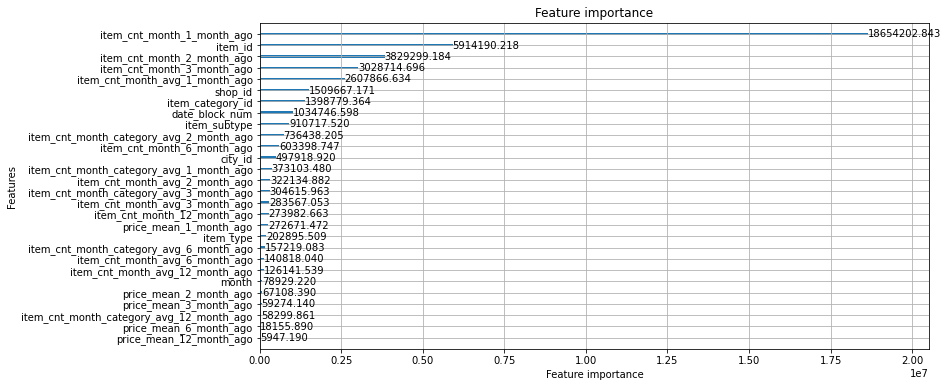

In [34]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, importance_type='gain', figsize=(12, 6))
plt.show()

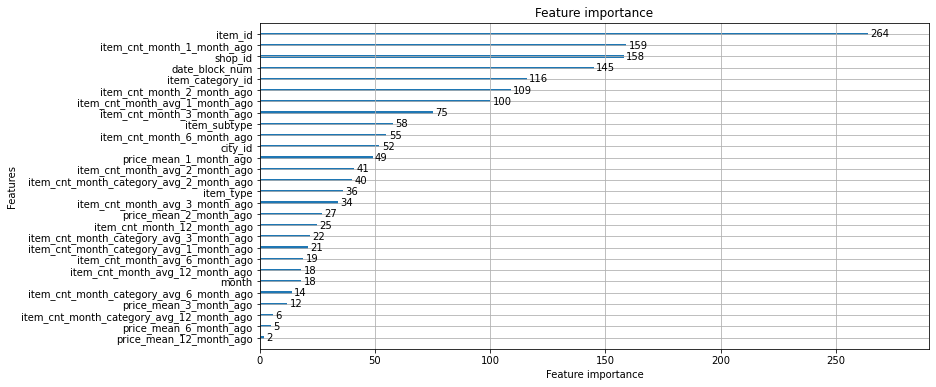

In [35]:
lgb.plot_importance(model, importance_type='split', figsize=(12, 6))
plt.show()

In [36]:
#model.best_score

In [37]:
#best_params

{'lambda_l1': 7.6916883039999915,
 'lambda_l2': 1.8801244342481942e-08,
 'num_leaves': 31,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'objective': 'regression',
 'metric': 'rmse',
 'learning_rate': 0.05}

## Prediction

In [38]:
val_pred = model.predict(test_df.drop(columns='ID'))

In [39]:
print(val_pred)

[0.58031055 0.20926303 0.9794886  ... 0.07137567 0.0656862  0.0656862 ]


# CSV作成

In [40]:
result_tmp = test_df
result_tmp['item_cnt_month'] = val_pred

In [41]:
result = result_tmp.loc[:,['ID','item_cnt_month']]

In [42]:
print(result)

              ID  item_cnt_month
10913756       0        0.580311
10913757       1        0.209263
10913758       2        0.979489
10913759       3        0.274682
10913760       4        1.791909
...          ...             ...
11127951  214195        0.187298
11127952  214196        0.117010
11127953  214197        0.071376
11127954  214198        0.065686
11127955  214199        0.065686

[214200 rows x 2 columns]


In [43]:
result.to_csv('submission.csv', index=False)